# **Fine-Grained Sentiment Analysis (5 classes) E-Commerce Reviews**

### Step 1: Install & Import Dependencies

In [1]:
!pip install -q transformers==4.41.2 peft==0.11.1 accelerate==0.31.0 datasets


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 37.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.6/251.6 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.4/309.4 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 66.6 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    confusion_matrix, ConfusionMatrixDisplay,
    classification_report, roc_auc_score, roc_curve, auc,
    brier_score_loss
)
from sklearn.calibration import calibration_curve
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity

import torch
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    Trainer, TrainingArguments, EarlyStoppingCallback, AutoConfig
)
from peft import LoraConfig, TaskType, get_peft_model

### Step 2: Mount Google Drive & Load Data

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

file_path = "/content/drive/MyDrive/E-Commerce Reviews (5 Classes).csv"
df = pd.read_csv(file_path, encoding='ISO-8859-1')
df = df[['Text', 'Sentiment']].dropna()
df.head()

Mounted at /content/drive


,Text,Sentiment
0,Absolutely wonderful - silky and sexy and comf...,Positive
1,Love this dress! it's sooo pretty. i happene...,Very Positive
2,I had such high hopes for this dress and reall...,Neutral
3,"I love, love, love this jumpsuit. it's fun, fl...",Very Positive
4,This shirt is very flattering to all due to th...,Very Positive


In [25]:
total_instances = len(df)
print(f"Total instances: {total_instances}")

sentiment_counts = df['Sentiment'].value_counts()
print("Number of instances per sentiment:")
print(sentiment_counts)

Total instances: 22641
Number of instances per sentiment:
Sentiment
Very Positive    12540
Positive          4908
Neutral           2823
Negative          1549
Very Negative      821
Name: count, dtype: int64


### Step 3: Visualize Dataset Distribution

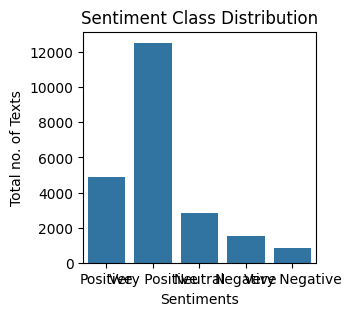

In [26]:
plt.figure(figsize=(3,3))
sns.countplot(data=df, x='Sentiment')
plt.title("Sentiment Class Distribution")
plt.xlabel("Sentiments")
plt.ylabel("Total no. of Texts")
plt.grid(False)
plt.show()


### Step 4: Encode Labels

In [27]:

# label_encoder = LabelEncoder()
# df['label'] = label_encoder.fit_transform(df['Sentiment'])

# print("Label Mapping:")
# for i, label in enumerate(label_encoder.classes_):
#     print(f"{label}: {i}")

sentiment_to_label = {
    "Very Negative": 0,
    "Negative": 1,
    "Neutral": 2,
    "Positive": 3,
    "Very Positive": 4
}

df['label'] = df['Sentiment'].map(sentiment_to_label)

print("Label Mapping:")
for sentiment, label in sentiment_to_label.items():
    print(f"{sentiment} → {label}")


Label Mapping:
Very Negative → 0
Negative → 1
Neutral → 2
Positive → 3
Very Positive → 4


### Step 5: Train-Test Split

In [28]:
train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    df['Text'].tolist(),
    df['label'].tolist(),
    test_size=0.2,
    random_state=42,
    stratify=df['label']
)

val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts,
    temp_labels,
    test_size=0.5,
    random_state=42,
    stratify=temp_labels
)

print(f"Train size: {len(train_texts)}, Val size: {len(val_texts)}, Test size: {len(test_texts)}")

Train size: 18112, Val size: 2264, Test size: 2265


### Step 6: Tokenization

In [29]:
base_model_name = "bert-base-multilingual-uncased"
finetuned_model_name = "nlptown/bert-base-multilingual-uncased-sentiment"
tokenizer = AutoTokenizer.from_pretrained(base_model_name)

train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=512)
val_encodings   = tokenizer(val_texts, truncation=True, padding=True, max_length=512)
test_encodings  = tokenizer(test_texts, truncation=True, padding=True, max_length=512)


### Step 7: Dataset Class

In [30]:
class SentimentDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()} | {'labels': torch.tensor(self.labels[idx])}

    def __len__(self):
        return len(self.labels)

train_dataset = SentimentDataset(train_encodings, train_labels)
val_dataset   = SentimentDataset(val_encodings, val_labels)
test_dataset  = SentimentDataset(test_encodings, test_labels)

### Step 8: Define Metrics Function

In [36]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    proba = torch.softmax(torch.tensor(logits), dim=-1).numpy()

    acc = accuracy_score(labels, preds) * 100
    prec, rec, f1, _ = precision_recall_fscore_support(labels, preds, average="macro")

    sims = []
    for i in range(len(labels)):
        true_onehot = np.zeros(proba.shape[1])
        true_onehot[labels[i]] = 1
        sims.append(cosine_similarity([true_onehot], [proba[i]])[0][0])
    similarity_score = np.mean(sims) * 100
    confidence_score = np.mean(np.max(proba, axis=1)) * 100

    return {
        "eval_accuracy": acc,
        "eval_precision": prec * 100,
        "eval_recall": rec * 100,
        "eval_f1": f1 * 100,
        "eval_similarity_score": similarity_score,
        "eval_confidence_score": confidence_score,
    }


### Step 9: Evaluate Without Fine-Tuning

In [37]:
baseline_model = AutoModelForSequenceClassification.from_pretrained(finetuned_model_name)

baseline_trainer = Trainer(
    model=baseline_model,
    args=TrainingArguments(
        output_dir="./results",
        per_device_eval_batch_size=32
    ),
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

baseline_metrics = baseline_trainer.evaluate()

print("\n===== Performance of Pretrained Transformer Model =====\n")

metrics_to_show = [
    "accuracy",
    "precision",
    "recall",
    "f1",
    "similarity_score",
    "confidence_score"
]

for metric in metrics_to_show:
    key = f"eval_{metric}"
    if key in baseline_metrics:
        print(f"{metric} is: {baseline_metrics[key]:.2f}%")

print("\n===== Evaluation Details =====")
print(f"Eval Loss: {baseline_metrics.get('eval_loss', 0.0):.4f}")
print(f"Runtime: {baseline_metrics.get('eval_runtime', 0.0)} sec")
print(f"Samples per second: {baseline_metrics.get('eval_samples_per_second', 0.0)}")


/usr/local/lib/python3.12/dist-packages/accelerate/accelerator.py:477: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)



===== Performance of Pretrained Transformer Model =====

accuracy is: 56.82%
precision is: 49.02%
recall is: 50.60%
f1 is: 47.80%
similarity_score is: 66.29%
confidence_score is: 63.43%

===== Evaluation Details =====
Eval Loss: 1.0163
Runtime: 5.7814 sec
Samples per second: 391.771


### Step 9.1: Confusion Matrix (Without Fine-Tuning)

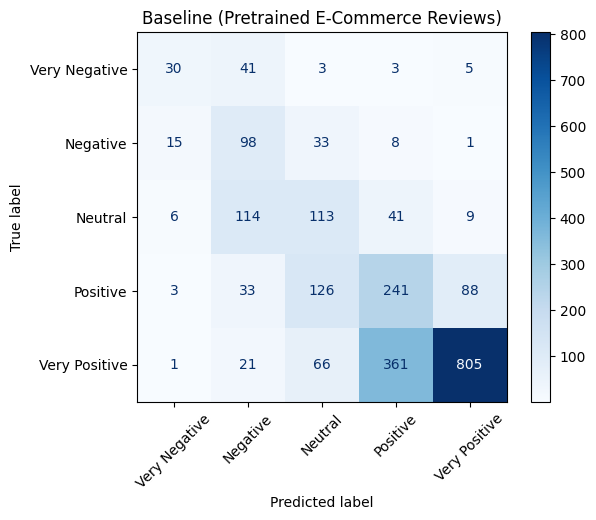

In [39]:
preds = baseline_trainer.predict(test_dataset)
y_true = preds.label_ids
y_pred = preds.predictions.argmax(-1)

cm = confusion_matrix(y_true, y_pred)

class_names = ["Very Negative", "Negative", "Neutral", "Positive", "Very Positive"]

ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names).plot(
    cmap="Blues", xticks_rotation=45
)
plt.title("Baseline (Pretrained E-Commerce Reviews)")
plt.show()

### Step 10: Base Model Fine-Tuning Configuration & Training

In [38]:
config = AutoConfig.from_pretrained(
    base_model_name,
    num_labels=5,
    hidden_dropout_prob=0.4,
    attention_probs_dropout_prob=0.3,
    classifier_dropout=0.4
)

model_base = AutoModelForSequenceClassification.from_pretrained(
    base_model_name,
    config=config
)

training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    weight_decay=0.01,
    warmup_ratio=0.1,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    logging_strategy="epoch",
    report_to="none",
    fp16=True,
    gradient_accumulation_steps=1,
    save_total_limit=2,
    max_grad_norm=1.0,
    lr_scheduler_type="cosine",
    seed=42,
    dataloader_pin_memory=True,
)

trainer_base = Trainer(
    model=model_base,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)],
)

trainer_base.train()


/usr/local/lib/python3.12/dist-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.12/dist-packages/accelerate/accelerator.py:477: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Similarity Score,Confidence Score
1,1.105400,0.919651,62.279152,28.892318,32.173332,29.776991,69.696784,69.952484
2,0.903000,0.836526,63.913428,43.016841,41.635892,40.674843,71.806698,71.200668
3,0.832000,0.839890,64.708481,48.683206,46.883668,43.476555,71.629398,72.061714
4,0.792800,0.824999,63.913428,48.015120,46.324679,46.529354,71.905777,70.701195
5,0.767600,0.831195,63.692580,47.713544,46.652143,46.664159,71.702155,70.869019


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


TrainOutput(global_step=5660, training_loss=0.8801604146249724, metrics={'train_runtime': 1223.5808, 'train_samples_per_second': 74.012, 'train_steps_per_second': 4.626, 'total_flos': 7818555603317760.0, 'train_loss': 0.8801604146249724, 'epoch': 5.0})

#### Step 10.1: Fine-Tuned Base Model Evaluation & Performance Analysis

In [41]:
finetuned_metrics = trainer_base.evaluate(test_dataset)

print("\n===== Performance after Fine-Tuning Base Model =====\n")

metrics_to_show = [
    "accuracy",
    "precision",
    "recall",
    "f1",
    "similarity_score",
    "confidence_score"
]

for metric in metrics_to_show:
    key = f"eval_{metric}"
    if key in finetuned_metrics:
        print(f"{metric} is: {finetuned_metrics[key]:.2f}%")

print("\n===== Evaluation Details =====")
print(f"Eval Loss: {finetuned_metrics.get('eval_loss', 0.0):.4f}")
print(f"Runtime: {finetuned_metrics.get('eval_runtime', 0.0)} sec")
print(f"Samples per second: {finetuned_metrics.get('eval_samples_per_second', 0.0)}")



===== Performance after Fine-Tuning Base Model =====

accuracy is: 65.78%
precision is: 52.05%
recall is: 50.18%
f1 is: 50.45%
similarity_score is: 72.57%
confidence_score is: 70.71%

===== Evaluation Details =====
Eval Loss: 0.8367
Runtime: 6.5814 sec
Samples per second: 344.151


#### Step 10.2: Confusion Matrix Analysis

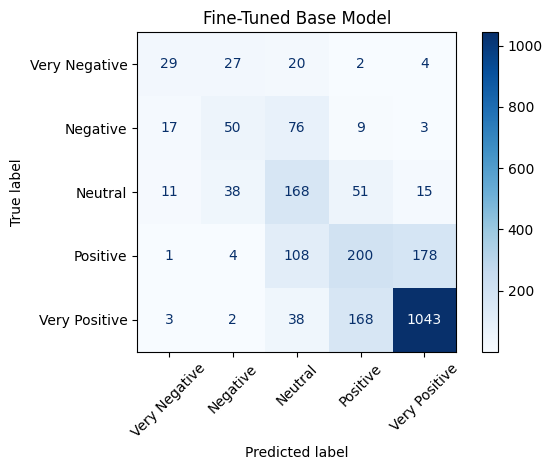

In [42]:
preds = trainer_base.predict(test_dataset)
y_true = preds.label_ids
y_pred = preds.predictions.argmax(-1)

cm = confusion_matrix(y_true, y_pred)

class_names = ["Very Negative", "Negative", "Neutral", "Positive", "Very Positive"]

ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names).plot(
    cmap="Blues",
    xticks_rotation=45
)
plt.title("Fine-Tuned Base Model")
plt.tight_layout()
plt.show()

#### Step 10.3: Training Progress Visualization & Loss Analysis

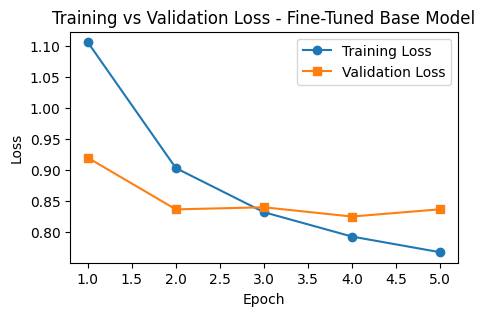

In [43]:
logs_base = trainer_base.state.log_history

train_loss_base = {}
eval_loss_base = {}

for log in logs_base:
    if "loss" in log and "epoch" in log:
        train_loss_base[float(log["epoch"])] = log["loss"]
    if "eval_loss" in log and "epoch" in log:
        eval_loss_base[float(log["epoch"])] = log["eval_loss"]

epochs_base = sorted(set(train_loss_base.keys()) | set(eval_loss_base.keys()))
train_vals_base = [train_loss_base.get(e, None) for e in epochs_base]
eval_vals_base = [eval_loss_base.get(e, None) for e in epochs_base]

# Plot
plt.figure(figsize=(5,3))
plt.plot(epochs_base, train_vals_base, label="Training Loss", marker="o")
plt.plot(epochs_base, eval_vals_base, label="Validation Loss", marker="s")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss - Fine-Tuned Base Model")
plt.legend()
plt.grid(False)
plt.show()


### Step 11: Adapter (LoRA) Model Configuration & Training

In [44]:
adapter_model = AutoModelForSequenceClassification.from_pretrained(
    base_model_name,
    num_labels=5
)

peft_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    r=8,
    lora_alpha=16,
    lora_dropout=0.4,
    target_modules=["query", "key", "value", "dense"],
    bias="none",
    modules_to_save=["classifier"]
)

adapter_model = get_peft_model(adapter_model, peft_config)
adapter_model.print_trainable_parameters()

adapter_args = TrainingArguments(
    output_dir="./results-adapter",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=1e-4,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=8,
    weight_decay=0.05,
    warmup_ratio=0.05,
    logging_dir="./logs-adapter",
    logging_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="eval_f1",
    greater_is_better=True,
    report_to="none",
    seed=42,
    fp16=True,
    gradient_accumulation_steps=1,
    max_grad_norm=1.0,
    logging_steps=100,
    save_total_limit=2,
    lr_scheduler_type="cosine",
    dataloader_pin_memory=True,
    remove_unused_columns=True
)

trainer_adapter = Trainer(
    model=adapter_model,
    args=adapter_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

trainer_adapter.train()

adapter_metrics = trainer_adapter.evaluate(test_dataset)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 1,343,237 || all params: 168,703,498 || trainable%: 0.7962


/usr/local/lib/python3.12/dist-packages/accelerate/accelerator.py:477: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Similarity Score,Confidence Score
1,1.028800,0.880238,63.383392,38.308334,35.628256,34.658293,70.666927,71.889725
2,0.827300,0.804711,64.620141,45.068299,44.019416,41.982331,72.663866,71.221588
3,0.771100,0.785894,65.812721,61.049672,48.573449,43.496250,73.246609,70.719055
4,0.736700,0.793391,64.620141,50.365456,50.127866,50.144206,72.773022,69.159561
5,0.699400,0.783127,65.547703,51.486994,45.068072,46.730968,73.333522,72.337448
6,0.671100,0.792242,65.326855,50.454966,48.302847,48.941997,73.119728,72.636124
7,0.655400,0.795452,65.680212,50.037984,48.011280,48.764715,73.224913,73.900101


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is dep

#### Step 11.1: Adapter (LoRA) Model Evaluation & Performance Analysis

In [46]:
adapter_metrics = trainer_adapter.evaluate(test_dataset)

print("\n===== Performance with Adapter (LoRA) =====\n")

metrics_to_show = [
    "accuracy",
    "precision",
    "recall",
    "f1",
    "similarity_score",
    "confidence_score"
]

for metric in metrics_to_show:
    key = f"eval_{metric}"
    if key in adapter_metrics:
        print(f"{metric} is: {adapter_metrics[key]:.2f}%")

print("\n===== Evaluation Details =====")
print(f"Eval Loss: {adapter_metrics.get('eval_loss', 0.0):.4f}")
print(f"Runtime: {adapter_metrics.get('eval_runtime', 0.0)} sec")
print(f"Samples per second: {adapter_metrics.get('eval_samples_per_second', 0.0)}")



===== Performance with Adapter (LoRA) =====

accuracy is: 67.64%
precision is: 54.68%
recall is: 54.61%
f1 is: 54.33%
similarity_score is: 74.33%
confidence_score is: 69.45%

===== Evaluation Details =====
Eval Loss: 0.7871
Runtime: 11.2392 sec
Samples per second: 201.526


#### Step 11.2: Confusion Matrix Analysis

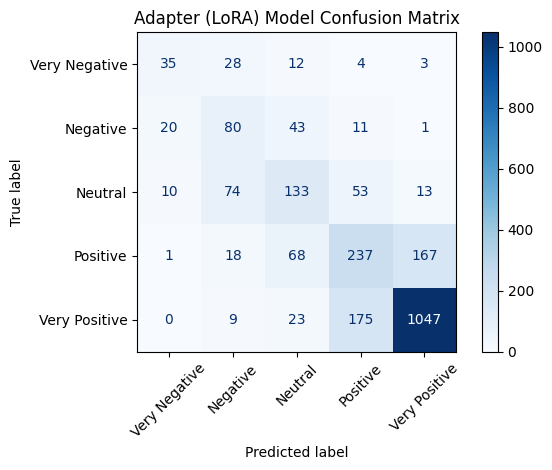

In [47]:
preds = trainer_adapter.predict(test_dataset)
y_true, y_pred = preds.label_ids, preds.predictions.argmax(-1)
cm = confusion_matrix(y_true, y_pred)
class_names = ["Very Negative", "Negative", "Neutral", "Positive", "Very Positive"]
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names).plot(cmap="Blues", xticks_rotation=45)
plt.title("Adapter (LoRA) Model Confusion Matrix")
plt.tight_layout()
plt.show()

#### Step 11.3: Training Progress Visualization & Loss Analysis

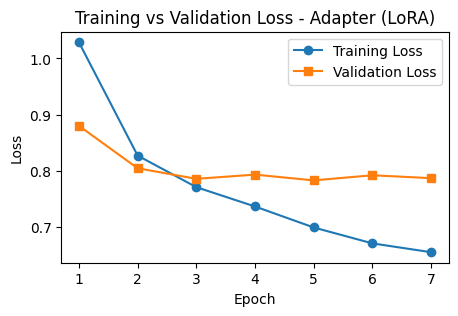

In [48]:
 logs_adapter = trainer_adapter.state.log_history

train_loss_adapter = {}
eval_loss_adapter = {}

for log in logs_adapter:
    if "loss" in log and "epoch" in log:
        train_loss_adapter[float(log["epoch"])] = log["loss"]
    if "eval_loss" in log and "epoch" in log:
        eval_loss_adapter[float(log["epoch"])] = log["eval_loss"]

epochs_adapter = sorted(set(train_loss_adapter.keys()) | set(eval_loss_adapter.keys()))
train_vals_adapter = [train_loss_adapter.get(e, None) for e in epochs_adapter]
eval_vals_adapter = [eval_loss_adapter.get(e, None) for e in epochs_adapter]

# Plot
plt.figure(figsize=(5,3))
plt.plot(epochs_adapter, train_vals_adapter, label="Training Loss", marker="o")
plt.plot(epochs_adapter, eval_vals_adapter, label="Validation Loss", marker="s")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss - Adapter (LoRA)")
plt.legend()
plt.grid(False)
plt.show()


### Step 12: Comprehensive Model Comparison & Performance Visualization

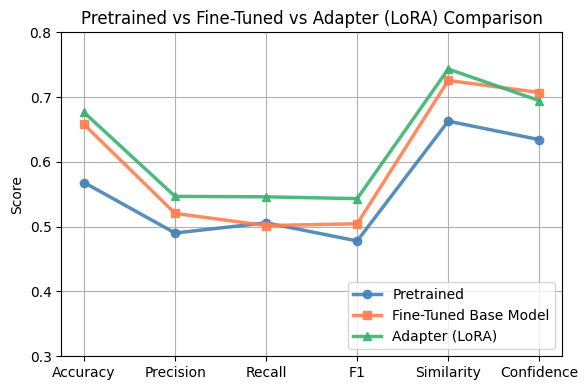

In [52]:
metrics = ["Accuracy", "Precision", "Recall", "F1", "Similarity", "Confidence"]

metric_keys = ["accuracy", "precision", "recall", "f1", "similarity_score", "confidence_score"]

pretrained_vals = np.array([baseline_metrics[f"eval_{k}"] for k in metric_keys]) / 100
base_vals       = np.array([finetuned_metrics[f"eval_{k}"] for k in metric_keys]) / 100
adapter_vals    = np.array([adapter_metrics[f"eval_{k}"] for k in metric_keys]) / 100

x = np.arange(len(metrics))

plt.figure(figsize=(6, 4))

plt.plot(x, pretrained_vals, marker='o', linestyle='-', linewidth=2.5, alpha=0.9, label="Pretrained", color='steelblue')
plt.plot(x, base_vals, marker='s', linestyle='-', linewidth=2.5, alpha=0.9, label="Fine-Tuned Base Model", color='coral')
plt.plot(x, adapter_vals, marker='^', linestyle='-', linewidth=2.5, alpha=0.9, label="Adapter (LoRA)", color='mediumseagreen')

plt.xticks(x, metrics, fontsize=10)
plt.ylabel("Score")
plt.ylim(0.30, 0.80)
plt.title("Pretrained vs Fine-Tuned vs Adapter (LoRA) Comparison")
plt.grid(True)
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()
